# Imports

In [1]:
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import HTML
from tqdm import tqdm
import numpy as np
import pandas as pd
import mujoco
from scipy.optimize import minimize
from base64 import b64encode
import os
import skvideo.io


MyoSuite:> Registering Myo Envs


# Utils functions

In [2]:
def show_video(video_path, video_width = 1080):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")


def plot_qpos(all_qpos, traj=None):

    all_qpos_array = np.array(all_qpos)

    plt.figure(figsize=(6, 4))
 
    if traj is not None:
        plt.plot(all_qpos_array[:,0], traj[:, 1], label='Reference qpos', linestyle='--')
 
    plt.plot(all_qpos_array[:,0], all_qpos_array[:,1] , label='Achieved qpos')
    
    # Format plot
    plt.xlabel('Time Step')
    plt.ylabel('qpos')
    plt.title('qpos History Over Time')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_uxxx(uxxx, muscle_names):
    """
    Plot muscle activations over time.
    uxxx[:,0] = time axis
    uxxx[:,1:] = muscle activation data (6 muscles)
    """
    num_muscles = uxxx.shape[1] - 1 
 
    fig, axs = plt.subplots(2, 3, figsize=(6, 4))
    axs = axs.flatten()
    line_objects = []
 
    for j in range(num_muscles):
        ax = axs[j]
        line, = ax.plot(uxxx[:, 0], uxxx[:, j+1])  
        line_objects.append(line)
        
        ax.set_xlim([uxxx[:, 0].min(), uxxx[:, 0].max()])
        ax.set_ylim([0, 1])
        ax.set_title(muscle_names[j])
        ax.set_xlabel('Time')
        ax.set_ylabel('Activation')
    
    plt.tight_layout()
    plt.show()

# Introduction
In this tutorial a target trajectory will be replicated by MyoElbow using [Computed Muscle Control](https://doi.org/10.1016/S0021-9290(02)00432-3), given a sequence of joint angles, angular velocity, and angular acceleration $\theta_{exp}, \dot{\theta}_{exp}, \ddot{\theta}_{exp}$, a sequence of muscle control *u* will be generated.

<div style="width:100%;">
    <img src="../images/CMC.png" alt="CMC framework" style="width:1200px; display:block; margin-left:auto; margin-right:auto;"/>
</div>

In [3]:
traj = pd.read_csv('data/9_trajectory.csv').values

In [4]:
model0 = loader.get_sim(None, 'elbow/myoelbow_1dof6muscles.xml')  # for static optimization
model1 = loader.get_sim(None, 'elbow/myoelbow_1dof6muscles.xml')  # for forward dynamics

# First stage (Calculate desired acceleration)

$$
	\ddot{\theta}_d = \ddot{\theta}_{exp}+k_v(\dot{\theta}_{exp}-\dot{\theta})+k_p(\theta_{exp}-\theta)
\tag{1}
$$

$\theta_{exp}, \dot{\theta}_{exp}, \ddot{\theta}_{exp}$ are the reference joint angle, angular velocity, and angular acceleration, respectively.

$\theta, \dot{\theta}$ are the joint angle and angular velocity of the model at the current time step, respectively.

$k_v, k_p$ are the velocity gain and position gain, respectively. 

To make the errors converge to zero in a critically damped manner, $k_v = 2 \sqrt{k_p}$.

Here we set $k_p = 100$ and $k_v = 20$.

In [5]:
kp = 100
kv = 2*np.sqrt(kp)

def get_des_acc(data, exp_pos, exp_vel, exp_acc):
    # Get the desired acceleration
    q = data.qpos
    qvel = data.qvel
    qacc_d = exp_acc + kv * (exp_vel - qvel) + kp * (exp_pos - q)
    return qacc_d

# Second stage (Static Optimaization)

For the static optimization problem, the performance criterion was chosen to be the sum of squared muscle activations:

$$
\min\sum_{m=1}^{N}(a_m^*)^2
$$
$$
\text{s.t. } \ddot{\theta^*}=\ddot{\theta_d}
$$
$$
0 \leq a_m \leq 1
\tag{2}
$$

In [6]:
def StaticOpt(model, data, qacc_d, max_iter=100):
    initial_state = np.concatenate([data.qpos, data.qvel])
    initial_act = data.act.copy()
    n_actuators = model.nu   

    def loss_fn(act):
        return 0.5 * np.sum(act**2)  

    def acceleration_constraint(act):
        mujoco.mj_resetData(model, data)
        data.qpos[:] = initial_state[:model.nq]
        data.qvel[:] = initial_state[model.nq:]
        data.act[:] = act
        mujoco.mj_step(model, data)
        return data.qacc - qacc_d 

    constraints = {
        'type': 'eq',
        'fun': acceleration_constraint,
        'tol': 1e-6
    }

    bounds = [(0, 1.0) for _ in range(n_actuators)]
    result = minimize(
        loss_fn,
        x0=initial_act,
        method='SLSQP', 
        bounds=bounds,
        constraints=constraints,
        options={'maxiter': max_iter, 'disp': False}
    )
    return result.x, result

# Third Stage (Muscle excitations controller) 

$$
u = a^* + k_u (a^* - a)
\tag{3}
$$

$$
u = clip(0,1,u)
$$

$u$ is the muscle activation, $a^*$ is the optimal muscle activations computed in stage 2, and $a$ is the current muscle activations in forward dynamic simulation, $k_u$ is the feedback gain.

Here we set $k_u = 2$.

In [7]:
def compute_u(opt_a, act):
    ku = 2
    u = opt_a + ku * (opt_a - act)
    u = np.clip(u, 0, 1.0)
    return u

# Fourth Stage (Forward Dynamics)

In [8]:
all_qpos = np.zeros((traj.shape[0], 2))
all_ctrl = np.zeros((traj.shape[0], 1+model1.nu))
data1 = mujoco.MjData(model1)

for idx in tqdm(range(traj.shape[0])):

    exp_pos = np.array([traj[idx, 1]])
    exp_vel = np.array([traj[idx, 2]])
    exp_acc = np.array([traj[idx, 3]])
    qacc_d = get_des_acc(data1, exp_pos, exp_vel, exp_acc)

    data0 = deepcopy(data1)

    opt_a, result = StaticOpt(model0, data0, qacc_d, max_iter=500)

    u = compute_u(opt_a, data1.act)

    data1.ctrl = u
    mujoco.mj_step(model1, data1)
    all_qpos[idx,:] = np.hstack((data1.time, data1.qpos))
    all_ctrl[idx,:] = np.hstack((data1.time, u))

100%|██████████| 501/501 [00:07<00:00, 63.05it/s]


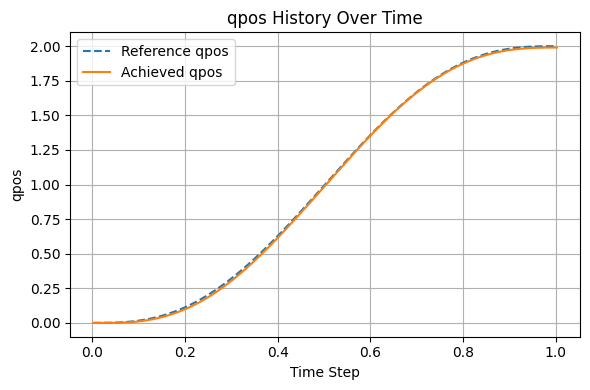

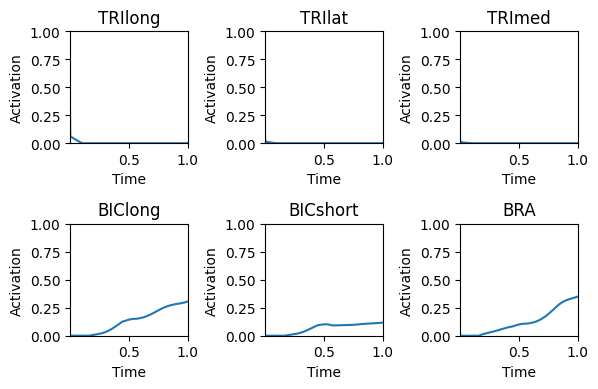

In [9]:
plot_qpos(all_qpos, traj)
muscle_names = [model1.actuator(i).name for i in range(model0.nu)]
plot_uxxx(all_ctrl, muscle_names)

In [10]:
# ---- initializations
model_ref = loader.get_sim(None, 'elbow/myoelbow_1dof6muscles.xml')
data_ref = mujoco.MjData(model_ref) # data for reference trajectory
model_test = loader.get_sim(None, 'elbow/myoelbow_1dof6muscles.xml')
data_test = mujoco.MjData(model_test) # test data for achieved trajectory

camera = mujoco.MjvCamera()
camera.azimuth = 0
camera.distance =  1.1070990185160428
camera.elevation = -10.232281643227267
camera.lookat = np.array([-0.1130067696435806, 0.0815790401272094, 1.0655519045043413])

options_ref = mujoco.MjvOption()
options_ref.flags[:] = 0
options_ref.flags[[1, 22]] = 1
options_ref.geomgroup[2:] = 0

options_test = mujoco.MjvOption()
options_test.flags[:] = 0
options_test.flags[[1, 4, 22]] = 1
options_test.geomgroup[:] = 1

renderer_ref = mujoco.Renderer(model_ref, width=1080, height=1080)
renderer_ref.scene.flags[:] = 0

renderer_test = mujoco.Renderer(model_test, width=1080, height=1080)
renderer_test.scene.flags[:] = 0

frames = []
for idx in tqdm(range(traj.shape[0])):
    data_ref.qpos = traj[idx, 1]
    mujoco.mj_step1(model_ref, data_ref)
    data_test.ctrl = all_ctrl[idx, 1:]
    mujoco.mj_step(model_test, data_test)
    if not idx % round(0.3/(model_test.opt.timestep*25)):
        renderer_ref.update_scene(data_ref, camera=camera, scene_option=options_ref)
        frame_ref = renderer_ref.render()
        renderer_test.update_scene(data_test, camera=camera, scene_option=options_test)
        frame_test = renderer_test.render()
        frame_merged = np.append(frame_ref, frame_test, axis=1)
        frames.append(frame_merged)

os.makedirs('videos', exist_ok = True)
output_name = 'videos/myoelbow_freemovement.mp4'
skvideo.io.vwrite(output_name, np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})

100%|██████████| 501/501 [00:00<00:00, 771.48it/s]


In [11]:
show_video(output_name)